In [23]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib as mpl
import numpy as np
from pathlib import Path


In [24]:
p = Path('D:/qs-analysis/compiled-data/se')
p2 = Path('D:/qs-analysis/compiled-data/Figure 2')
if not (p2 / 'Data.pkl').exists() and not (p2 / 'mfi.pkl').exists():
    files = list(p.glob('**/*.pkl'))
    df = pd.DataFrame(columns=['FITC-A','AHL','IPTG','Family','Replicate'])
    for f in files:
        family = str(f.parent).split('\\')[-1]
        tmp = pd.read_pickle(f)
        df = df.append(tmp,ignore_index=True)
else:
    Data = pd.read_pickle(p2 / 'Data.pkl')
    mfi = pd.read_pickle(p2 / 'mfi.pkl')


In [25]:
def colorFader(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(mpl.colors.to_hex((1-mix[i])*c1 + mix[i]*c2))
    return cols

def AHL_cmap(Family,n,r=False):
    if Family == 'LuxR':
        c2='#ffffff' #white
        c1='#003f5c' #blue
        if not r:
            Lux_rgbs = colorFader(c1,c2,n)
        else:
            Lux_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Lux_rgbs, name='LuxR')
    elif Family == 'LasR':
        c2='#ffffff' #white
        c1='#dd1c77' #pink #
        if not r:
            Las_rgbs = colorFader(c1,c2,n)
        else:
            Las_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Las_rgbs, name='LasR')
    elif Family == 'TraR':
        c2='#ffffff' #white
        c1='#644895' #purple #
        if not r:
            Tra_rgbs = colorFader(c1,c2,n)
        else:
            Tra_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Tra_rgbs, name='TraR')
def AHL_cols(Family,n):
    if Family == 'LuxR':
        c2='#ffffff' #white
        c1='#003f5c' #blue
        return colorFader(c1,c2,n)
    elif Family == 'LasR':
        c2='#ffffff' #white
        c1='#dd1c77' #pink #
        return colorFader(c1,c2,n)

    elif Family == 'TraR':
        c2='#ffffff' #white
        c1='#644895' #purple #
        return colorFader(c1,c2,n)

In [26]:
def clean_df(df):
    data = df
    data['FITC-A'] = data['FITC-A'] - data[data.Family=='WT']['FITC-A'].median()
    data = data[data.Family != 'WT']

    data.IPTG = (data.IPTG * 1e3)
    data.IPTG = data.IPTG.astype('int16')

    gb = data.groupby(['AHL','IPTG','Family'])
    
    lg = gb.AHL.transform(np.log10).sort_values()
    lg[lg == -np.inf] = 0
    lg = lg.astype('int32')
    lg.name = 'logAHL'
    return pd.concat([data,lg],axis=1)


if not (p2 / 'Data.pkl').exists() and not (p2 / 'mfi.pkl').exists():
    Data = clean_df(df)
    mfi = Data.groupby(['IPTG','Family','logAHL','Replicate']).median().reset_index()
    mfi['R'] = mfi.groupby(['Family','IPTG','Replicate'])['FITC-A'].transform(lambda x: x.max()/x.min())
    Data.to_pickle(p2 / 'Data.pkl')
    mfi.to_pickle(p2 / 'mfi.pkl')

In [27]:
def make_heatmap(median_fluorescence,Family,ax=None, **kwargs):
    """
    This is a function to generate heatmaps
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    # sns.set_context('paper')
    ax = ax or plt.gca()
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    # normalized
    norm = mfi[mfi.logAHL != 0].copy()
    norm['FITC-A']=norm['FITC-A']/norm.groupby(['AHL','IPTG']).mean().max()['FITC-A']*100

    piv = norm.pivot_table(index='IPTG', columns='logAHL', values='FITC-A')
    g = sns.heatmap(piv, vmin=0,ax=ax,**kwargs)
    cbar = g.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75,100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.set_ylabel('Relative Expression Level')
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'IPTG ($\mu M$)')
    #f.tight_layout()
    return 

In [28]:
Lux_cmap = AHL_cmap('LuxR',100)
Las_cmap = AHL_cmap('LasR',100)
Tra_cmap = AHL_cmap('TraR',100)
Lux_cmap_r = AHL_cmap('LuxR',100,r=True)
Las_cmap_r = AHL_cmap('LasR',100,r=True)
Tra_cmap_r = AHL_cmap('TraR',100,r=True)

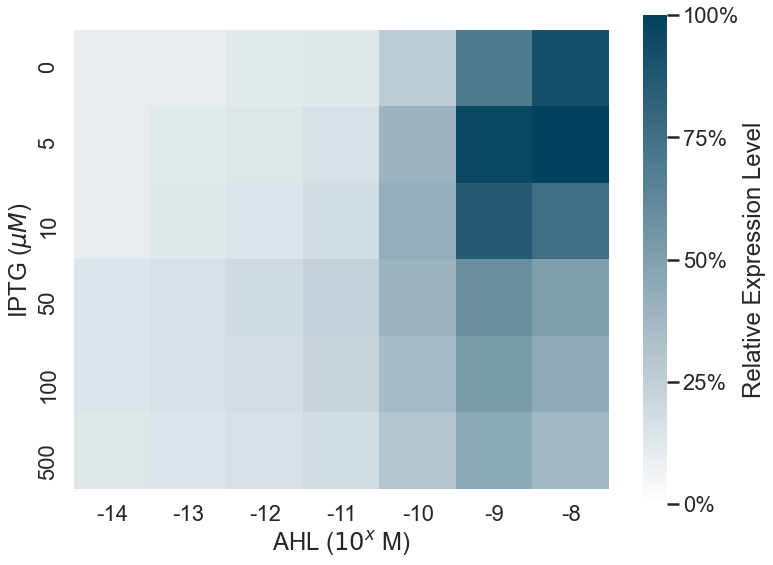

In [29]:

sns.set_context('poster')
sns.set_style('white')
f, ax = plt.subplots(figsize=(12,9))
make_heatmap(mfi,'LasR',ax,cmap=Lux_cmap_r,square=True)
f.savefig('../Figures/LasR.png',dpi=1200,bbox_inches='tight',transparent=True)
